In [1]:
import torch
import yaml
import types
import json

import numpy as np
import matplotlib.patches as patches

import sys
dir = '/home/jjwhit/rcGAN/'
sys.path.append(dir)

from data.lightning.MassMappingDataModule import MMDataModule
from data.lightning.MassMappingDataModule import MMDataTransform
from models.lightning.mmGAN import mmGAN
from mass_map_utils.scripts.ks_utils import backward_model
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours
import matplotlib.ticker as tkr
from scipy.stats import pearsonr #Correlation function
# from skimage.metrics import  peak_signal_noise_ratio as psnr
from mpl_toolkits.axes_grid1 import make_axes_locatable

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def load_object(dct):
    return types.SimpleNamespace(**dct)

In [4]:
torch.set_float32_matmul_precision('medium')

with open(dir+'configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint(
        #REMEMBER TO CHANGE TO CORRECT MODEL
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_3/checkpoint_best.ckpt')

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [5]:
np_gts = {f"{i}": np.load(f"/share/gpu0/jjwhit/samples/np_gt_{i}.npy") for i in range(1, 11)}
np_samps = {f"{i}": np.load(f"/share/gpu0/jjwhit/samples/np_samps_{i}.npy") for i in range(1, 11)}
np_avgs = {f"{i}": np.load(f"/share/gpu0/jjwhit/samples/np_avgs_{i}.npy") for i in range(1, 11)}
np_stds = {f"{i}": np.load(f"/share/gpu0/jjwhit/samples/np_stds_{i}.npy") for i in range(1, 11)}
#array['i'] to access samples; for samples np_samps['i']['j'] where j are the 32 posterior samples.

In [6]:
np_samps['1'].shape

(32, 300, 300)

In [7]:
#Choose which set of samples to plot: (range(1,11))
map = '8'

In [8]:
std1 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std1.npy', allow_pickle=True
)
std2 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std2.npy', allow_pickle=True
)

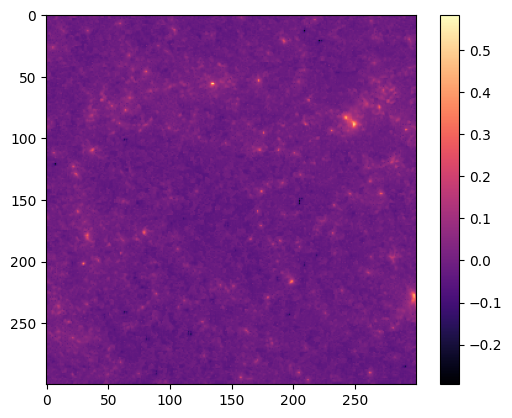

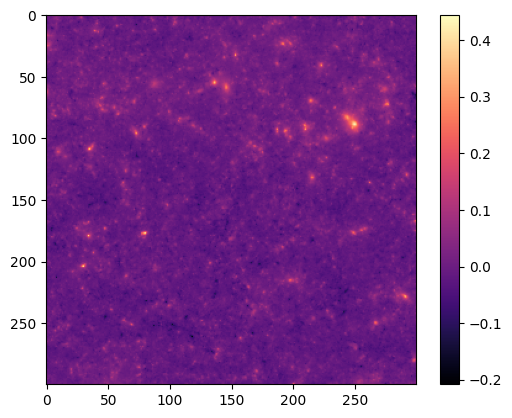

In [9]:
plt.imshow(np_samps[map][30].real,  cmap='magma')
plt.colorbar()
plt.show()
plt.imshow(np_gts[map].real,  cmap='magma')
plt.colorbar()

In [9]:
method = 'mmGAN'
zoom_length = 80  # Adjust this value based on your preference
margin = 10  # Adjust this value to set the margin

# Ensure the square is not touching the edge
zoom_startx = np.random.randint(margin, cfg.im_size - zoom_length - margin)
zoom_starty1 = np.random.randint(margin, int(cfg.im_size / 2) - zoom_length - margin)
zoom_starty2 = np.random.randint(int(cfg.im_size / 2) + margin, cfg.im_size - zoom_length - margin)

p = np.random.rand()
zoom_starty = zoom_starty1 if p <= 0.5 else zoom_starty2

x_coord = zoom_startx + zoom_length
y_coords = [zoom_starty, zoom_starty + zoom_length]


mask =  np.load(
    cfg.cosmo_dir_path + 'cosmos_mask.npy', allow_pickle=True
).astype(bool)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [10]:
contours = find_contours(mask, 0.5)
outer_contour = max(contours, key=lambda x: x.shape[0])

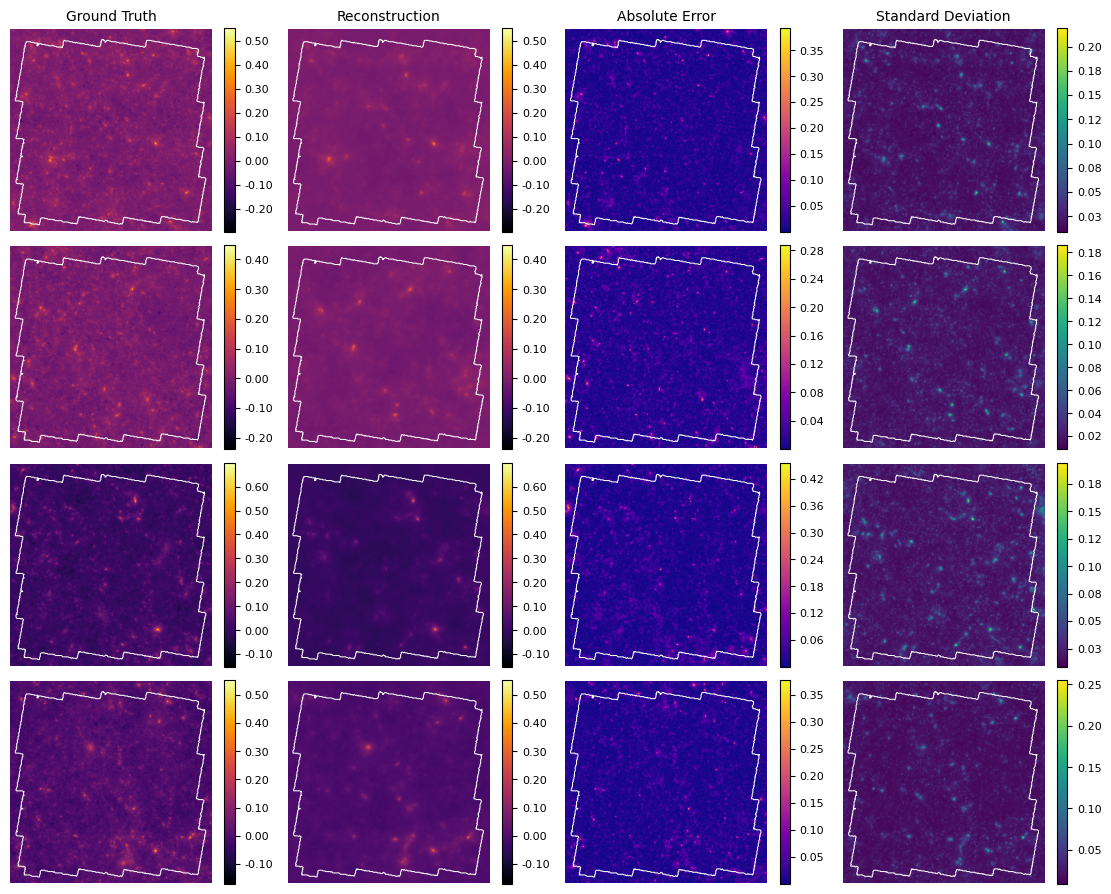

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(14, 12))
for i, map in enumerate(['3', '4', '9','6']):
    vmin = np.min(np_gts[map].real)
    vmax = np.max(np_gts[map].real)
    
    im1 = axes[i, 0].imshow(np_gts[map].real, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
    axes[i, 0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
    if i == 0:
        axes[i, 0].set_title('Ground Truth')
    axes[i, 0].axis('off')
    
    im2 = axes[i, 1].imshow(np_avgs[map].real, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
    axes[i, 1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
    if i == 0:
        axes[i, 1].set_title('Reconstruction')
    axes[i, 1].axis('off')
    
    im3 = axes[i, 2].imshow(np.abs(np_avgs[map].real-np_gts[map].real), cmap='plasma', vmin=np.min(np.abs(np_avgs[map]-np_gts[map])),
                            vmax=np.max(np.abs(np_avgs[map]-np_gts[map])), origin='lower')
    axes[i, 2].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
    if i == 0:
        axes[i, 2].set_title('Absolute Error')
    axes[i, 2].axis('off')
    
    im4 = axes[i, 3].imshow(np_stds[map].real, cmap='viridis', vmin=np.min(np_stds[map].real), vmax=np.max(np_stds[map].real), origin='lower')
    axes[i, 3].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
    if i == 0:
        axes[i, 3].set_title('Standard Deviation')
    axes[i, 3].axis('off')
    
    cbar1 = fig.colorbar(im1, ax=axes[i, 0], format=tkr.FormatStrFormatter('%.2f'), shrink=.75)
    cbar2 = fig.colorbar(im2, ax=axes[i, 1], format=tkr.FormatStrFormatter('%.2f'), shrink=.75)
    cbar3 = fig.colorbar(im3, ax=axes[i, 2], format=tkr.FormatStrFormatter('%.2f'), shrink=.75)
    cbar4 = fig.colorbar(im4, ax=axes[i, 3], format=tkr.FormatStrFormatter('%.2f'), shrink=.75)

    cbar3.locator = tkr.MaxNLocator(nbins=8)  # Adjust the number of ticks as needed
    cbar3.update_ticks()

plt.subplots_adjust(wspace=0.1, hspace=-0.2)
plt.show()
# plt.savefig('/share/gpu0/jjwhit/plots/new/big_overview_1.png', bbox_inches='tight', dpi=300)

In [25]:
map='10'

In [34]:
from lenspack.geometry.projections import gnom
def get_extend_radec(res, width):
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size = res #arcmin
    dx = np.deg2rad(width*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

In [35]:
COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]

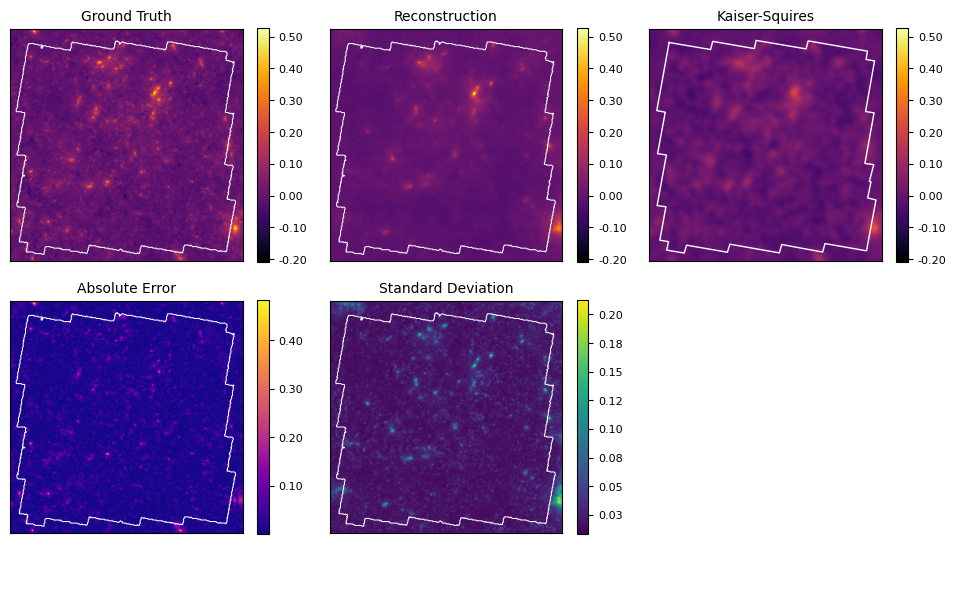

In [40]:
#FIG 1: Gt, recon, error, std
ra, dec = np.array(COSMOS_VERTICES).T
fig, axes = plt.subplots(2,3, figsize=(12,8))
for axis in axes.flatten():
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

vmin = np.min(np_gts[map].real)
vmax = np.max(np_gts[map].real)

im1 = axes[0,0].imshow(np_gts[map].real, cmap='inferno', vmin = vmin, vmax = vmax, origin='lower')
axes[0,0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[0,0].set_title('Ground Truth')

im2 = axes[0,1].imshow(np_avgs[map].real, cmap='inferno', vmin = vmin, vmax = vmax, origin='lower')
axes[0,1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[0,1].set_title('Reconstruction')

im3 = axes[1,0].imshow(np.abs(np_avgs[map].real-np_gts[map].real),cmap='plasma',vmin=np.min(np.abs(np_avgs[map].real-np_gts[map].real)), 
                       vmax = np.max(np.abs(np_avgs[map].real-np_gts[map].real)),origin='lower')
axes[1,0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[1,0].set_title('Absolute Error')

im4 = axes[1,1].imshow(np_stds[map].real, cmap='viridis', vmin=np.min(np_stds[map].real), vmax = np.max(np_stds[map].real), origin='lower')
axes[1,1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.75)
axes[1,1].set_title('Standard Deviation')

kernel = MMDataTransform.compute_fourier_kernel(cfg.im_size)
gamma_sim = MMDataTransform.forward_model(np_gts[map], kernel) + (
            std1 * np.random.randn(cfg.im_size, cfg.im_size) + 1.j * std2 * np.random.randn(cfg.im_size, cfg.im_size)
        )
backward = backward_model(gamma_sim, kernel)
ks = ndimage.gaussian_filter(backward, sigma=1/.29)

im5 = axes[0,2].imshow(np.flipud(ks.real), cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real), extent=get_extend_radec(0.29, 300))
axes[0,2].plot(ra, dec, c='w', lw=1)
axes[0,2].set_title('Kaiser-Squires')


axes[1, 2].axis('off')

cbar1 = fig.colorbar(im1, ax=axes[0,0],format=tkr.FormatStrFormatter('%.2f'), shrink=0.68)
cbar2 = fig.colorbar(im2, ax=axes[0,1],format=tkr.FormatStrFormatter('%.2f'), shrink=0.68)
cbar5 = fig.colorbar(im5, ax=axes[0,2],format=tkr.FormatStrFormatter('%.2f'), shrink=0.68)
cbar3 = fig.colorbar(im3, ax=axes[1,0],format=tkr.FormatStrFormatter('%.2f'), shrink=0.68)
# cbar3.locator = tkr.MaxNLocator(nbins=7)
# cbar3.update_ticks()
cbar4 = fig.colorbar(im4, ax=axes[1,1],format=tkr.FormatStrFormatter('%.2f'), shrink=0.68)
plt.subplots_adjust(wspace=0.1, hspace=-0.21)



plt.savefig(f'/share/gpu0/jjwhit/plots/new/overview_{int(map)}.png', bbox_inches='tight', dpi=300)
# plt.show()

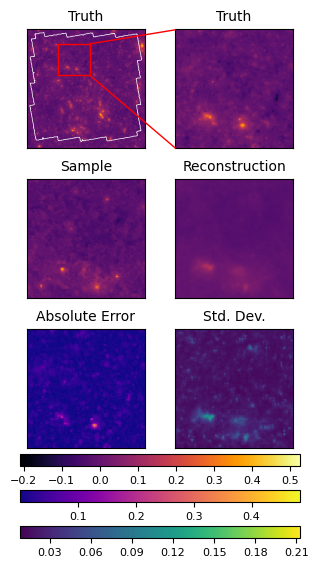

In [43]:
# Plot 2: Truth; zoomed truth, sample, reconstruction, error and std dev.
nrow = 3
ncol = 2

fig = plt.figure(figsize=(ncol*2, nrow*2))

gs = gridspec.GridSpec(nrow, ncol,
                    wspace=0.25, hspace=0,
                    top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                    left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))

ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_gts[map].real, cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('Truth')

ax1 = ax
rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                            edgecolor='r',
                            facecolor='none')

ax.add_patch(rect)
ax = plt.subplot(gs[0, 1])
im1 = ax.imshow(np_gts[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
            cmap='inferno',
            vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('Truth')

connection_path_1 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty],
                                            [0, 0], coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_1)
connection_path_2 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty + zoom_length], [0, zoom_length],
                                            coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_2)

for samp in range(1):
    ax = plt.subplot(gs[1, samp])
    ax.imshow(np_samps[map][samp][zoom_starty:zoom_starty + zoom_length,
                zoom_startx:zoom_startx + zoom_length].real, cmap='inferno', 
                vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
    ax.set_title('Sample')

ax = plt.subplot(gs[1, 1])
ax.imshow(
    np_avgs[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('Reconstruction')

ax = plt.subplot(gs[2, 0])
im2 = ax.imshow(np.abs(np_avgs[map][zoom_starty:zoom_starty + zoom_length,    
            zoom_startx:zoom_startx + zoom_length] - np_gts[map][zoom_starty:zoom_starty + zoom_length,
            zoom_startx:zoom_startx + zoom_length]), cmap='plasma', vmin=np.min(np.abs(np_avgs[map] - np_gts[map])),
                vmax=np.max(np.abs(np_avgs[map] - np_gts[map])))
ax.set_title("Absolute Error")

ax = plt.subplot(gs[2, 1])
im3 = ax.imshow(np_stds[map][zoom_starty:zoom_starty + zoom_length,
            zoom_startx:zoom_startx + zoom_length].real, cmap='viridis', vmin=np.min(np_stds[map].real),
            vmax=np.max(np_stds[map].real))
ax.set_title('Std. Dev.')

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labelleft=False)

cbaxes = fig.add_axes([0.15, 0.12, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, ax=ax, orientation='horizontal', cax=cbaxes)
cbaxes = fig.add_axes([0.15, 0.06, 0.7, 0.02])
cbar = fig.colorbar(im2, ax=ax, orientation='horizontal', cax=cbaxes)
cbar.locator = tkr.MaxNLocator(nbins=6)
cbar.update_ticks()
cbaxes = fig.add_axes([0.15, 0.0, 0.7, 0.02])
cbar = fig.colorbar(im3, ax=ax, orientation='horizontal', cax=cbaxes)
cbar.locator = tkr.MaxNLocator(nbins=7)
cbar.update_ticks()

    
plt.savefig(f'/share/gpu0/jjwhit/plots/new/zoomed_overview_10.png', bbox_inches='tight', dpi=300) #{int(map)}
#plt.show()

In [25]:
zoom_length = 120  # Adjust this value based on your preference
margin = 10  # Adjust this value to set the margin

# Ensure the square is not touching the edge
zoom_startx = np.random.randint(margin, cfg.im_size - zoom_length - margin)
zoom_starty1 = np.random.randint(margin, int(cfg.im_size / 2) - zoom_length - margin)
zoom_starty2 = np.random.randint(int(cfg.im_size / 2) + margin, cfg.im_size - zoom_length - margin)

p = np.random.rand()
zoom_starty = zoom_starty1 if p <= 0.5 else zoom_starty2

x_coord = zoom_startx + zoom_length
y_coords = [zoom_starty, zoom_starty + zoom_length]

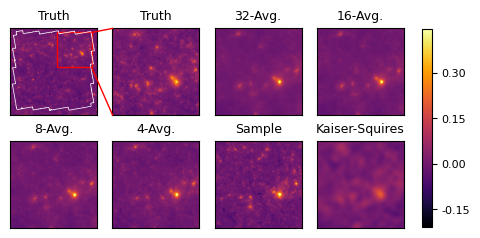

In [26]:
#Plot 3: truth; zoomed truth, reconstruction, 8-, 4-, 2-avg, sample, std. dev.

nrow = 2
ncol = 4

fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.1, hspace=0.3,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))

ax = plt.subplot(gs[0, 0])
ax.imshow(np_gts[map].real, cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
plt.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('Truth',  fontsize=9)

ax1 = ax
rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                            edgecolor='r',
                            facecolor='none')

ax.add_patch(rect)
ax = plt.subplot(gs[0, 1])
im = ax.imshow(np_gts[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
            cmap='inferno',
            vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('Truth',  fontsize=9)

connection_path_1 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty],
                                            [0, 0], coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_1)
connection_path_2 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty + zoom_length], [0, zoom_length],
                                            coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_2)

ax = plt.subplot(gs[0,2])
ax.imshow(
    np_avgs[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('32-Avg.',  fontsize=9)

ax = plt.subplot(gs[1, 1])
avg = np.zeros((cfg.im_size, cfg.im_size), dtype=np.complex128)
for l in range(4):
    avg += np_samps[map][l]

avg = avg / 4
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('4-Avg.',  fontsize=9)


ax = plt.subplot(gs[1, 0])
avg = np.zeros((cfg.im_size, cfg.im_size), dtype=np.complex128)
for l in range(8):
    avg += np_samps[map][l]
avg = avg / 8

ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('8-Avg.',  fontsize=9)


for samp in range(1):
    ax = plt.subplot(gs[1,2])
    ax.imshow(np_samps[map][samp][zoom_starty:zoom_starty + zoom_length,
                zoom_startx:zoom_startx + zoom_length].real, cmap='inferno', 
                vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
    ax.set_title('Sample',  fontsize=9)

ax = plt.subplot(gs[1,3])
kernel = MMDataTransform.compute_fourier_kernel(cfg.im_size)
gamma_sim = MMDataTransform.forward_model(np_gts[map], kernel) + (
            std1 * np.random.randn(cfg.im_size, cfg.im_size) + 1.j * std2 * np.random.randn(cfg.im_size, cfg.im_size)
        )
backward = backward_model(gamma_sim, kernel)
ks = ndimage.gaussian_filter(backward, sigma=1/.29)

ax.imshow(
    ks[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('Kaiser-Squires',  fontsize=9)

ax = plt.subplot(gs[0,3])
avg = np.zeros((cfg.im_size, cfg.im_size), dtype=np.complex128)
for l in range(16):
    avg += np_samps[map][l]

avg = avg / 16
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('16-Avg.',  fontsize=9)

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labelleft=False)

cbar_ax = fig.add_axes([0.93, 0.17, 0.02, 0.66]) 
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))
cbar.locator = tkr.MaxNLocator(nbins=5)
cbar.update_ticks()

plt.savefig(f'/share/gpu0/jjwhit/plots/new/zoomed_aes_{int(map)}.png', bbox_inches='tight', dpi=300)
# plt.show()

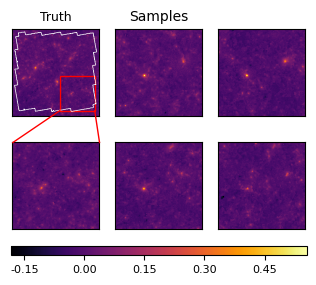

In [52]:
#Plot 4: Zoomed diversity.
nrow = 2
ncol = 3
fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.1, hspace=0.3,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))

ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_gts[map].real, cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
plt.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('Truth',  fontsize=9)

ax1 = ax
rect = patches.Rectangle((zoom_startx, zoom_starty), zoom_length, zoom_length, linewidth=1,
                            edgecolor='r',
                            facecolor='none')

ax.add_patch(rect)

ax = plt.subplot(gs[1, 0])
ax.imshow(np_gts[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
            cmap='inferno',
            vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))

connection_path_1 = patches.ConnectionPatch([zoom_startx + zoom_length, zoom_starty + zoom_length], [zoom_length, 0],
                                            coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_1)
connection_path_2 = patches.ConnectionPatch([zoom_startx, zoom_starty + zoom_length], [0, 0],
                                            coordsA=ax1.transData,
                                            coordsB=ax.transData, color='r')
fig.add_artist(connection_path_2)
for samp in range(2):
    ax = plt.subplot(gs[0, samp + 1])
    ax.imshow(np_samps[map][samp][zoom_starty:zoom_starty + zoom_length,
            zoom_startx:zoom_startx + zoom_length].real, cmap='inferno',
                vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
    if samp==0:
        ax.set_title('Samples')

for samp in range(2):
    ax = plt.subplot(gs[1, samp + 1])
    ax.imshow(np_samps[map][samp+2][zoom_starty:zoom_starty + zoom_length,
            zoom_startx:zoom_startx + zoom_length].real, cmap='inferno',
                vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labelleft=False)


cbar_ax = fig.add_axes([0.13, 0.08, 0.74, 0.03]) 
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))
cbar.locator = tkr.MaxNLocator(nbins=5)
cbar.update_ticks()

plt.savefig(f'/share/gpu0/jjwhit/plots/new/diversity_{int(map)}.png', bbox_inches='tight', dpi=300)
# plt.show()

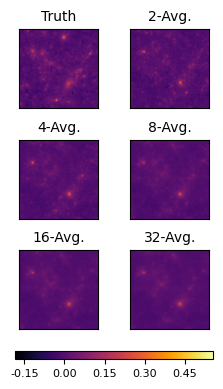

In [161]:
# #Plot 5: zoomed P-ascent.
nrow = 3
ncol = 2
fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.25, hspace=0.4,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))


ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_gts[map][zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
            cmap='inferno',
            vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('Truth')

ax1 = ax
ax = plt.subplot(gs[0, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(2):
    avg += np_samps[map][l]

avg = avg / 2
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('2-Avg.')


ax = plt.subplot(gs[1, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(4):
    avg += np_samps[map][l]

avg = avg / 4
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('4-Avg.')


ax = plt.subplot(gs[1, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(8):
    avg += np_samps[map][l]

avg = avg / 8
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('8-Avg.')


ax = plt.subplot(gs[2, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(16):
    avg += np_samps[map][l]

avg = avg / 16
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('16-Avg.')

ax = plt.subplot(gs[2, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(32):
    avg += np_samps[map][l]

avg = avg / 32
ax.imshow(
    avg[zoom_starty:zoom_starty + zoom_length, zoom_startx:zoom_startx + zoom_length].real,
    cmap='inferno', vmin=np.min(np_gts[map].real), vmax=np.max(np_gts[map].real))
ax.set_title('32-Avg.')

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labelleft=False)


cbar_ax = fig.add_axes([0.17, 0.05, 0.66, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))
cbar.locator = tkr.MaxNLocator(nbins=5)
cbar.update_ticks()

#plt.savefig(ff'/share/gpu0/jjwhit/plots/new/zoom_P_ascent_{int(map)}.png', bbox_inches='tight', dpi=300)
plt.show()

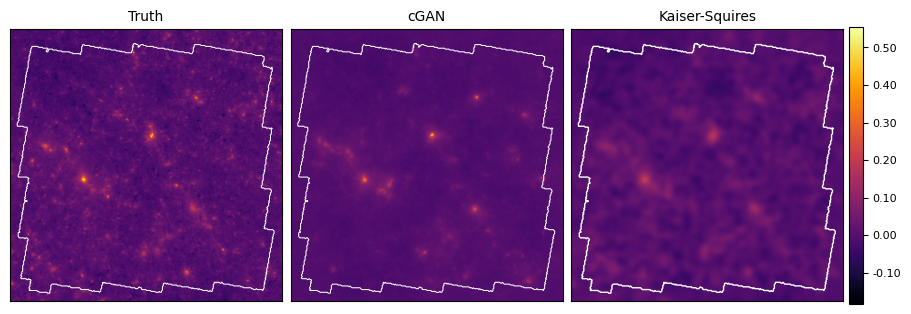

In [110]:
#Plot 6: Kaiser Squires comparison
kernel = MMDataTransform.compute_fourier_kernel(cfg.im_size)
gamma_sim = MMDataTransform.forward_model(np_gts[map], kernel) + (
            std1 * np.random.randn(cfg.im_size, cfg.im_size) + 1.j * std2 * np.random.randn(cfg.im_size, cfg.im_size)
        )
backward = backward_model(gamma_sim, kernel)
ks = ndimage.gaussian_filter(backward, sigma=1/.29)

nrow = 1
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(9,3), constrained_layout=True)

for axis in axes.flatten():
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


vmin = np.min(np_gts[map].real)
vmax = np.max(np_gts[map].real)

im1 = axes[0].imshow(np_gts[map].real, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
axes[0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=0.75)
axes[0].set_title('Truth')

im2 = axes[1].imshow(np_avgs[map].real, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
axes[1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=0.75)
axes[1].set_title('cGAN')

im4 = axes[2].imshow(ks.real, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
axes[2].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=1)
axes[2].set_title('Kaiser-Squires')

cbar4 = fig.colorbar(im4, ax=axes[2], orientation='vertical', pad=0.02,format=tkr.FormatStrFormatter('%.2f'))
cbar4.mappable.set_clim(vmin, vmax)

plt.savefig(f'/share/gpu0/jjwhit/plots/new/ks_comp_{int(map)}.png', bbox_inches='tight', dpi=300)
# plt.show()

In [113]:
map='9'

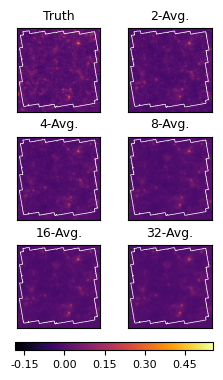

In [119]:
#Plot 7: P-ascent.
nrow = 3
ncol = 2
fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.25, hspace=0.3,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))


ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_gts[map].real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('Truth', fontsize=9)

ax1 = ax

ax = plt.subplot(gs[0, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(2):
    avg += np_samps[map][l]

avg = avg / 2
ax.imshow(avg.real,cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('2-Avg.', fontsize=9)


ax = plt.subplot(gs[1, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(4):
    avg += np_samps[map][l]

avg = avg / 4
ax.imshow(avg.real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('4-Avg.', fontsize=9)


ax = plt.subplot(gs[1, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(8):
    avg += np_samps[map][l]

avg = avg / 8
ax.imshow(avg.real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('8-Avg.', fontsize=9)


ax = plt.subplot(gs[2, 0])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)
for l in range(16):
    avg += np_samps[map][l]

avg = avg / 16
ax.imshow(avg.real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('16-Avg.', fontsize=9)

ax = plt.subplot(gs[2, 1])
avg = np.zeros((cfg.im_size,cfg.im_size), dtype=np.complex128)

for l in range(32):
    avg += np_samps[map][l]
avg = avg / 32
ax.imshow(avg.real, cmap='inferno', vmin=vmin, vmax=vmax)
ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('32-Avg.', fontsize=9)

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labelleft=False)


cbar_ax = fig.add_axes([0.17, 0.07, 0.66, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))
cbar.locator = tkr.MaxNLocator(nbins=5)
cbar.update_ticks()

plt.savefig(f'/share/gpu0/jjwhit/plots/new/P_ascent_{int(map)}.png', bbox_inches='tight', dpi=300)
# plt.show()

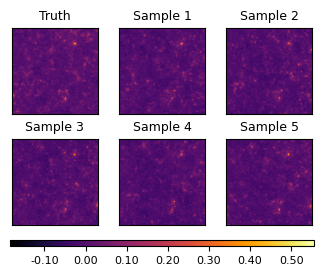

In [126]:
# Plot 8: Posterior samples.
nrow = 2
ncol = 3
fig = plt.figure(figsize=(ncol + 1, nrow + 1))

gs = gridspec.GridSpec(nrow, ncol,
                        wspace=0.25, hspace=0.25,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1))


ax = plt.subplot(gs[0, 0])
im = ax.imshow(np_gts[map].real, cmap='inferno', vmin=vmin, vmax=vmax)
#ax.plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=.5)
ax.set_title('Truth', fontsize=9)

ax1 = ax

for samp in range(2):
    ax = plt.subplot(gs[0, samp+1])
    ax.imshow(np_samps[map][samp].real, cmap='inferno', 
                vmin=vmin, vmax=vmax)
    ax.set_title(f'Sample {samp + 1}', fontsize=9)

for samp in range(3):
    ax = plt.subplot(gs[1, samp])
    ax.imshow(np_samps[map][samp+3].real, cmap='inferno', 
                vmin=vmin, vmax=vmax)
    ax.set_title(f'Sample {samp + 3}', fontsize=9)

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labelleft=False)



cbar_ax = fig.add_axes([0.12, 0.1, 0.76, 0.02])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=0.8,format=tkr.FormatStrFormatter('%.2f'))


plt.savefig(f'/share/gpu0/jjwhit/plots/new/samples_new_{int(map)}.png', bbox_inches='tight', dpi=300)
# plt.show()

In [48]:
# Compute correlation function between uncertainties
#RUN this again
r_a = []
p_a = []
for n in range(1,11):
    num = f'{n}'
    abs_flat = np.abs(np_avgs[num].real-np_gts[num].real)
    abs_flat[mask==0] = 0
    abs_flat = abs_flat.flatten()
    #abs_flat = np_avgs['10'].flatten()
    std_flat = np_stds[num]
    std_flat[mask==0] = 0
    std_flat = std_flat.flatten()
    
    r, p = pearsonr(abs_flat.real, std_flat.real)
    r_a.append(r)
    p_a.append(p)

In [49]:
np.mean(r_a)

0.4301279520473348

In [52]:
# Compute correlation function of reconstruction
r_b = []
p_b = []
for n in range(1,11):
    num = f'{n}'
    recon_flat = np_avgs[num].real
    recon_flat[mask==0] = 0
    recon_flat = recon_flat.flatten()
    gt_flat = np_gts[num].real
    gt_flat[mask==0] = 0
    gt_flat = gt_flat.flatten()
    
    r, p = pearsonr(recon_flat, gt_flat)
    r_b.append(r)
    p_b.append(p)

In [53]:
np.mean(r_b)

0.5692788842081702

In [62]:
r_n = []
p_n = []
gt_flat = np_gts['1'].real
gt_flat[mask==0] = 0
gt_flat = gt_flat.flatten()

for n in range(32):
    avg_flat = np.mean(np_samps['1'][:n], axis=0)
    has_nan_avg = np.isnan(avg_flat).any()
    avg_flat[mask==0] = 0
    avg_flat = avg.real.flatten()

    # has_nan_avg = np.isnan(avg_flat).any()
    
    if has_nan_avg:
        print("avg_flat contains NaN values.")
   
    r, p = pearsonr(avg_flat, gt_flat)
    r_n.append(r)
    p_n.append(p)

avg_flat contains NaN values.


ValueError: array must not contain infs or NaNs

In [132]:
r_n

[]

ValueError: x and y must have same first dimension, but have shapes (32,) and (0,)

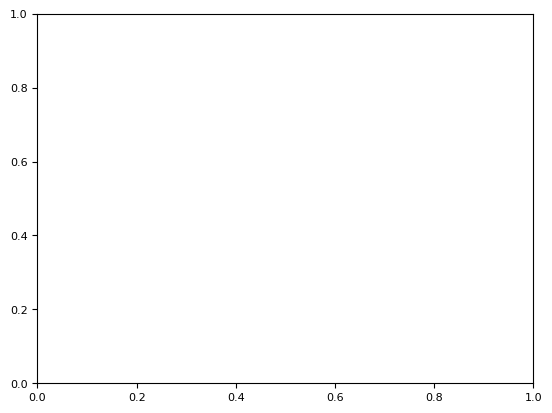

In [133]:
n_values = range(1, 33)
plt.plot(n_values, r_n, marker='.')
plt.xlabel('Number of Samples Averaged, N')
plt.ylabel('Pearson Correlation Coefficient, r')
plt.title('Pearson correlation coefficient vs Number of Samples used in Reconstruction')
plt.grid(True)
plt.show()

In [11]:

from skimage.metrics import  peak_signal_noise_ratio as psnr_sp

In [12]:
#Plot p-val vs PSNR
map = f'{1}'
psnr_vals = []
for p in range(1, 33):
    avg_img = np.mean(np_samps[map][:p].real, axis=0) #same as how we make recon
    psnr_instance = psnr_sp(np_gts[map].real, avg_img)
    psnr_vals.append(psnr_instance)

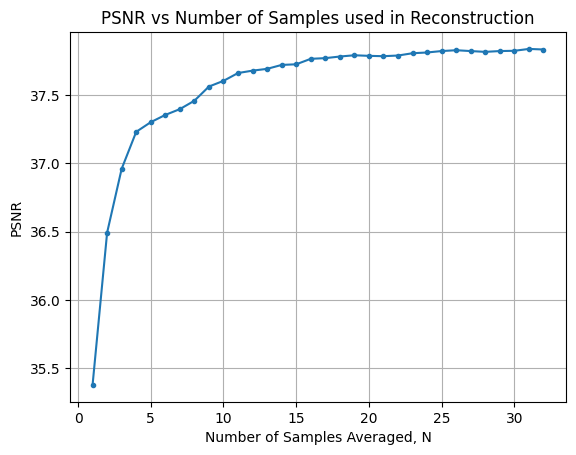

In [13]:
n_values = range(1, 33)
plt.plot(n_values, psnr_vals, marker='.')
plt.xlabel('Number of Samples Averaged, N')
plt.ylabel('PSNR')
plt.title('PSNR vs Number of Samples used in Reconstruction')
plt.grid(True)
plt.show()
# plt.savefig(f'/share/gpu0/jjwhit/plots/final/p_vs_psnr_2.png',bbox_inches='tight', dpi=300)

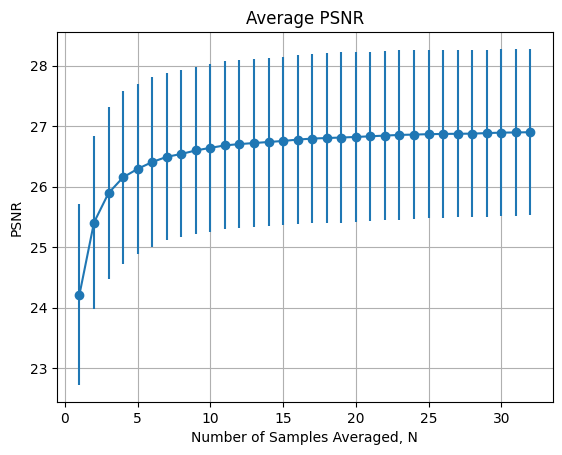

In [9]:
psnr_values_per_map = [[] for _ in range(10)]

for i in range(10):
    map_name = f'{i+1}'
    psnr_vals = []
    for p in range(1, 33):
        avg_img = np.mean(np_samps[map_name][:p].real, axis=0)
        psnr_instance = psnr(np_gts[map_name].real, avg_img) 
        psnr_vals.append(psnr_instance)
    psnr_values_per_map[i] = psnr_vals

mean_psnr = np.mean(psnr_values_per_map, axis=0)
std_dev_psnr = np.std(psnr_values_per_map, axis=0)


n_values = range(1, 33)
plt.errorbar(n_values, mean_psnr, yerr=std_dev_psnr, fmt='o', linestyle='-')
plt.xlabel('Number of Samples Averaged, N')
plt.ylabel('PSNR')
plt.title('Average PSNR')
plt.grid(True)
plt.show()